# Getting Started with the Signal API using Python

Note: run `pip install -r requirements.txt` to install the dependencies for this notebook

In [ ]:
!pip install -r requirements.txt

In [2]:
import backoff
import requests
import json
import os
import pandas as pd
import matplotlib
import math
from tqdm import tqdm

# Introduction

Welcome to the Signal API data science tutorial. 
In this notebook we will explore how to interact with the Signal API using Python.

This Getting Started guide is designed to complement the full documentation for the API which can be found at:

https://api.signal-ai.com/docs


## What can I do with the Signal API?

The Signal API provides a new and interesting way to search and explore news stories by examining which entities and topics appear in which stories, and when.

### Entities
A set of people, organisations, locations, substances, diseases and products identified by the Signal system. 
Mentions of entities are tracked along with their saliency (prominence) and sentiment (positive, neutral or negative).

### Topics
Over 300 topics (or themes), from Health to Blockchain, relevant to businesses.

### Documents
Documents are news stories with associated metadata such as publication date, url (if available), language, media type, publication source and title. 
Each document is supplied with a list of entities and topics.
The full text for each news story is not currently available through the API.

### Queries

The following are examples of questions one could answer using the Signal API:

> How many documents mentioned a company in relation to the Environment this year?

> Do mentions of a company have more positive or negative sentiment when a particular individual or location is also mentioned? How has this evolved over time? Does this depend on the publication source?

> Which topics, locations, organisations are most frequently mentioned alongside a particular individual?

> How many documents mention entity A but not entity B

During this tutorial we'll gradually build up the knowledge to answer these questions.


## Outline

Firstly we will explore some basic usage of the API such as authentication and the pagination system.
Then we'll explore the different topics and entities available before building some search queries.

We'll be using the popular requests library to communicate with the API and pandas to manipulate and visualise the data but prior experience with these libraries is not required.

Before we start lets make sure this machine can contact the Signal API using the requests library.

In [3]:
response = requests.get("https://api.signal-ai.com")
if response.ok:
    print('Successfully sent a request to the Signal API')
else:
    print('Error: Cannot communicate with the signal API')

Successfully sent a request to the Signal API


# Authentication

You will need a `client_id` and `client_secret` to gain access to the API.
The code below will assume they have been set and the environment variables `SIGNAL_API_CLIENT_ID` and `SIGNAL_API_CLIENT_SECRET` respectively.

Using your credentials you can request a temporary access token from the API using the url:

`https://api.signal-ai.com/auth/token`

Since we will be using this token a lot lets create a small class to authenticate against the signal API using the requests library.

We'll also add a method called `request` that can be used to send queries to the API with the new temporary access token. Keep in mind this token is only valid for 24 hours and you may need to call `authenticate` to request a new token from time to time.

In [5]:
def authenticate(client_id, client_secret, url = "https://api.signal-ai.com"):
    """ obtain a temporary access token using user credentials """
    token_url = f'{url}/auth/token'
    payload = {
        "grant_type": "client_credentials",
        "client_id": client_id,
        "client_secret": client_secret
    }
    response = requests.post(token_url, data=payload)
    return response.json().get("access_token")

Once authenticated the token will last for 24 hours.

In [11]:
TEMP_ACCESS_TOKEN = authenticate(os.environ['SIGNAL_API_CLIENT_ID'], os.environ['SIGNAL_API_CLIENT_SECRET'])
if TEMP_ACCESS_TOKEN:
    print('Congratulations! You have an access token, it will last for 24 hours before you will need to reauthenticate by repeating this step')
else:
    print('Error: Perhaps the credentials are incorrect?')

Congratulations! You have an access token, it will last for 24 hours before you will need to reauthenticate by repeating this step


## Making a Simple Request

Here's an example request showing how to use the access token.
The results will always come back as JSON.
We'll explore the specific endpoints and parameters in more detail later.
Notice the `next-cursor` key in the results.
By default ten results are returned in each response, to get the next 10 we need to paginate.

In [12]:
response = requests.get(
    # call the entities endpoint
    'https://api.signal-ai.com/entities',
    params={
        # Look for entities containing the token 'Environment'
        'name':'Environment',
        # Limit the search to organisations
        'type':'organisation'
    },
    # include the access token in the header
    headers={
        "Authorization": f'Bearer {TEMP_ACCESS_TOKEN}',
        "Content-Type": "application/json",
    }
)

response.json()

{'entities': [{'id': '90807375-17f6-33e8-bb92-ec9f01edd002',
   'type': 'organisation',
   'name': 'Environment Agency'},
  {'id': '1faef841-f0f3-3c19-b2ec-a3636a53c193',
   'type': 'organisation',
   'name': 'Environment America'},
  {'id': 'd5cdbaf4-7c60-35cc-bc54-a2105d934d8d',
   'type': 'organisation',
   'name': 'FCC Environment'},
  {'id': '2effe979-2394-4d36-935f-69472137c552',
   'type': 'organisation',
   'name': 'Delta Energy & Environment'},
  {'id': 'fda464ae-d49a-3b85-8036-fdad290aeff5',
   'type': 'organisation',
   'name': 'European Environment Agency'},
  {'id': 'b720bdd9-f30f-3c6d-b676-24fbb12e5ec7',
   'type': 'organisation',
   'name': 'Global Environment Facility'},
  {'id': '0223d7fb-3619-364c-91dd-cec95b0942cb',
   'type': 'organisation',
   'name': 'National Environment Agency'},
  {'id': '9c3e01a0-b102-408e-8e03-4b81ce3f3992',
   'type': 'organisation',
   'name': 'Veolia Environment UK'},
  {'id': '12567466-95e6-3f25-a082-87f195ec0f40',
   'type': 'organisatio

# Rate Limiting and Retries

Sometimes if the usage limits of the API are exceeded or if there is a short connection issue you may need to repeat a failed request.
The backoff library is a really easy way to do this.
It's a good idea to use backoff if you are making a lot or requests in a script or function, otherwise a single error might cause it to terminate.
Let's use backoff and put together everything so far in a simple function

In [13]:
# retry requests with an exponentially increasing wait time upto 10 times
@backoff.on_exception(backoff.expo, requests.exceptions.RequestException, max_value=10)
def request(method, endpoint, params=None, json=None):
    """ Make get requests using a tempory access token """
    response = requests.request(
        method,
        f'https://api.signal-ai.com/{endpoint}',
        params=params,
        json=json,
        headers={
            "Authorization": f'Bearer {TEMP_ACCESS_TOKEN}',
            "Content-Type": "application/json",
        },
    )
    
    # Check the latest response was valid, if not raise an exception
    # and retry using backoff
    response.raise_for_status()
    return response


request('GET', 'entities', {'name': 'Environment'}).json()

{'entities': [{'id': '90807375-17f6-33e8-bb92-ec9f01edd002',
   'type': 'organisation',
   'name': 'Environment Agency'},
  {'id': '1faef841-f0f3-3c19-b2ec-a3636a53c193',
   'type': 'organisation',
   'name': 'Environment America'},
  {'id': 'd5cdbaf4-7c60-35cc-bc54-a2105d934d8d',
   'type': 'organisation',
   'name': 'FCC Environment'},
  {'id': '2effe979-2394-4d36-935f-69472137c552',
   'type': 'organisation',
   'name': 'Delta Energy & Environment'},
  {'id': 'fda464ae-d49a-3b85-8036-fdad290aeff5',
   'type': 'organisation',
   'name': 'European Environment Agency'},
  {'id': 'b720bdd9-f30f-3c6d-b676-24fbb12e5ec7',
   'type': 'organisation',
   'name': 'Global Environment Facility'},
  {'id': '0223d7fb-3619-364c-91dd-cec95b0942cb',
   'type': 'organisation',
   'name': 'National Environment Agency'},
  {'id': '9c3e01a0-b102-408e-8e03-4b81ce3f3992',
   'type': 'organisation',
   'name': 'Veolia Environment UK'},
  {'id': '12567466-95e6-3f25-a082-87f195ec0f40',
   'type': 'organisatio

# Pagination

In the previous example the response contained a `next-cursor` key. 
By default, responses contain 10 items and the `next-cursor` allows us to get the next page of 10 items.
If there is no `next-cursor` key then there are no more items remaining.
To get the next page, use the token provided by `next-cursor` in your next request as the `from-cursor`


Example:

In [14]:
# Pagination Example:

page_0 = request('GET', 'entities', {'name': 'Environment'})

page_1 = requests.get(
    # call the entities endpoint
    'https://api.signal-ai.com/entities',
    params={
        # Look for entities containing the token 'Environment'
        'name':'Environment',
        # Limit the search to organisations
        'type':'organisation',
        # 'from-cursor' is found under the'next-cursor' key in the previous response
        'from-cursor': page_0.json().get('next-cursor')
        
    },
    # include the access token in the header
    headers={
        "Authorization": f'Bearer {TEMP_ACCESS_TOKEN}',
        "Content-Type": "application/json",
    }
)

page_1.json()

{'entities': [{'id': '2bc185aa-55a2-3e41-bfc3-0111f5fab9ef',
   'type': 'organisation',
   'name': 'Natural Environment Research Council'},
  {'id': '22d74a22-2037-3638-9cd6-a209937ddce0',
   'type': 'organisation',
   'name': 'Scottish Environment Protection Agency'},
  {'id': 'f293ed81-8409-45f3-9ccf-e001d91d7eba',
   'type': 'organisation',
   'name': 'United Nations Environment Programme'},
  {'id': '7bcf2193-66c2-3103-b401-8b7a1195e457',
   'type': 'organisation',
   'name': 'National Environment & Planning Agency (NEPA)'},
  {'id': 'dab8c776-cee6-34ef-a128-fa403819e079',
   'type': 'organisation',
   'name': 'Nicholas School of the Environment'},
  {'id': '748a0af9-8d42-3ce3-975f-d82be60b6475',
   'type': 'organisation',
   'name': 'Minister of Environment, Forestry and Fisheries'},
  {'id': '44bba16a-15b1-3249-a209-3ec52a7538cc',
   'type': 'organisation',
   'name': 'Department for Environment, Food and Rural Affairs'},
  {'id': '92996fa4-a09a-333e-b6c5-f352ce8b7736',
   'type'

Because we will frequently need to iterate over pages returned from the API, let's create a class called Paginate to manage this for us. 

In [15]:
from urllib.parse import urlparse, parse_qs

def response_to_url(response) -> str:
    """ get the url from a response """
    obj = urlparse(response.request.url)
    return f"{obj.scheme}://{obj.netloc}{obj.path}"

def response_to_params(response) -> dict:
    """ get the params from a response """
    obj = urlparse(response.request.url)
    return parse_qs(obj.query)

def response_to_body(response) -> dict:
    body = response.request.body
    return json.loads(body.decode()) if body is not None else {}


class Paginate:
    """ 
    A class to iterate over API requestes
    """
    
    def __init__(self, response):
        self.response = response

    def __iter__(self):
        return self
    
    def _get(self, response):
        """ get the next get request from the previous one """
        nxt = response.json().get('next-cursor', None)
        # the absence of next-cursor signifies we have reached the final page
        if not nxt:
            return None
        params = response_to_params(response)
        params['from-cursor'] = nxt
        return requests.request(
                'GET',
                response_to_url(response),
                headers=response.request.headers,
                params=params,
        )
    
    def _post(self, response):
        nxt = response.json().get('next-cursor', None)
        if not nxt:
            return None
        body = response_to_body(response)
        body['from-cursor'] = nxt
        return requests.request(
                'POST',
                response_to_url(response),
                headers=response.request.headers,
                json=body,
        )
        
    # retry requests with an exponentially increasing wait time upto 10 times
    @backoff.on_exception(backoff.expo, requests.exceptions.RequestException, max_value=10)
    def __next__(self):
        """ get the next response from the previous one """
        response = self.response

        # Check if we have reached the final page
        if not response:
            raise StopIteration()
            
        # Check the latest response was valid
        response.raise_for_status()
        
        method = response.request.method
        if method == 'GET':
            self.response = self._get(response)
        elif method == 'POST':
            self.response = self._post(response)
        else:
            raise ValueError(f'{method} method not supported')

        return response


Now we can easily loop over pages in a pythonic way. 
Below we get all the the results for our search by iterating over all the pages.

In [16]:
results = []
response = request('GET', 'entities', {'name': 'Environment'})
for page in Paginate(response):
    results.extend(page.json()['entities'])
print(f'{len(results)} results found')

34 results found


# The Discovery Endpoints

We now have all we need to explore all of the API endpoints in detail.
We'll start with the discovery endpoints since they are the simplest, and illustrate their usage using code.
Use these endpoints to discover which entities and topics are in the system,
we will use the ids returned later in our subsequent searches. 

In [17]:
"""
Entities are named people, organisations, locations, substances, diseases and products
which all have a unique identifier within the Signal API.
"""

def get_entity(uuid):
    """ Get a specific entity by its unique identifier """
    return request('GET', f'entities/{uuid}').json().get('entity')

def search_entities(name: str = None, typ: str = None, size: int = None):
    """
    Search for entities using any combination of name and type

    name: Any entity whose name contains this search term will match
    type: Enum: "person" "organisation" "location" "substance" "disease" "product"
    size: number of entities per response (affects page size, not search results)
    """
    response = request('GET', 'entities', {'name': name, 'type': typ, 'size': size})
    results = []
    for page in Paginate(response):
        results.extend(page.json().get('entities'))
    return results

We can search for entities with any combination of `name` and `type` fields.

In [18]:
search_entities(name="Conservation", typ="organisation")[:5]

[{'id': '5bdecdce-04dd-3ceb-ba8f-1b472a83d526',
  'type': 'organisation',
  'name': 'Butterfly Conservation'},
 {'id': '68b27557-7502-30a6-8dcf-526489e3056f',
  'type': 'organisation',
  'name': 'Conservation International'},
 {'id': '1e599e39-0ce4-3807-af6e-3b8a2ef228b2',
  'type': 'organisation',
  'name': 'Australian Conservation Foundation'},
 {'id': '6a29ecbc-a8e8-3a73-b172-5efe4901b8e4',
  'type': 'organisation',
  'name': 'Marine Conservation Society'},
 {'id': '38415152-9bc6-42ae-9c5d-52ab47f6ddba',
  'type': 'organisation',
  'name': 'Rare (conservation organization)'}]

In [19]:
# get a specific entity by id
get_entity('6a29ecbc-a8e8-3a73-b172-5efe4901b8e4')

{'id': '6a29ecbc-a8e8-3a73-b172-5efe4901b8e4',
 'type': 'organisation',
 'name': 'Marine Conservation Society'}

Topics and Sources have very similar interfaces

In [20]:
""" 
Signal experts have trained over 300 topics (or themes), 
from Health to Blockchain to provide clients an easy way 
to track emerging trends relevant to their businesses. """

def get_topic(uuid):
    """ Get a topic by id """
    return request('GET', f'topics/{uuid}').json().get('topic')

def search_topics(name: str = None, size=10, private=False):
    """
    Search A.I. trained topics by name

    name: Any topic whose name contains this search term will match
    size: number of entities per request (effects performance, not search results)
    private: Only return topics which are private to your organisation
    """
    response = request('GET', 'topics', {'name': name, 'size': size, 'private': str(private).lower()})
    results = []
    for page in Paginate(response):
        results.extend(page.json().get('topics'))
    return results

In [21]:
search_topics(name='Energy')

[{'id': '5fc92ab4-5f28-4daa-844a-ebd73d9a7b5c', 'name': 'Energy'},
 {'id': '5133baea-2428-4d63-b2a3-e93b106ea6ed', 'name': 'Renewable Energy'}]

In [22]:
def get_sources(uuid):
    """ Get a publication source by id """
    return self.request('GET', f'sources/{uuid}').json().get('source')

def search_sources(
    name: str = None, size: int = None, country: str = None,
    region: str = None, subregion: str = None
):
    """
    Search publication sources

    name: Any publication whose name contains this search term will match
    size: number of entities per request (effects performance, not search results)
    country: Country name
    region: Region name
    subregion: Subregion name
    """
    response = request(
        'GET',
        'sources',
        {
            'name': name, 'size': size, 'country': country,
            'region': region, 'subregion': subregion
        }
    )
    results = []
    for page in Paginate(response):
        results.extend(page.json().get('sources'))
    return results

In [23]:
search_sources(name='Guardian', country='United Kingdom')[:5]

[{'id': '670b2548-9e2f-4574-8662-45277a24e933',
  'name': 'The Lancaster Guardian',
  'country': 'United Kingdom',
  'subregion': 'Northern Europe',
  'region': 'Europe'},
 {'id': '48230d60-2a9a-42d7-b8f6-9599ea306da3',
  'name': 'Wandsworth Guardian',
  'country': 'United Kingdom',
  'subregion': 'Northern Europe',
  'region': 'Europe'},
 {'id': 'd93b93b9-301b-4ce2-856e-1e5df669ff28',
  'name': 'Wimbledon Guardian',
  'country': 'United Kingdom',
  'subregion': 'Northern Europe',
  'region': 'Europe'},
 {'id': '7508b207-8589-419d-8157-7f61969fd9f5',
  'name': 'Crewe & Nantwich Guardian',
  'country': 'United Kingdom',
  'subregion': 'Northern Europe',
  'region': 'Europe'},
 {'id': 'df2138c7-adac-44f7-b10e-056c4d2745d5',
  'name': 'East London & West Essex Guardian',
  'country': 'United Kingdom',
  'subregion': 'Northern Europe',
  'region': 'Europe'}]

# Search Endpoint

The search endpoint allows the user to search for documents.
Each document is tagged with metadata such as date of publication, language and all of the topics, sources and entities mentioned in the document.
In addition the sentiment, saliency and sentiment of each mention is available.
This makes the search endpoint a good way to explore when different tags are mentioned as well as how they occur with other topics and entities.

The search endpoint is very powerful and offers a lot of freedom.
To see all the possibilities it's best to look at the API docs.
Here we will explore some examples to get a flavour for what is possible.
The query needs to be provided as a JSON object and represents a filter for which documents are relevant.
Keep in mind that very broad queries might take a long time to return all the results.

Make sure you look at the documentation if you want to take full advantage of this endpoint:

https://api.signal-ai.com/docs#tag/Content-search

In [24]:
def search_documents(query):
    documents = []
    response = request('POST', 'search', json=query)
    n_pages = response.json().get('stats').get('total')
    n_pages /= len(response.json().get('documents'))
    # Use a progress bar, big queries may take some time
    for page in tqdm(Paginate(response), total=math.ceil(n_pages)):
        documents.extend(page.json()['documents'])
    return documents

Let's look at an example query and the results

## Example 1: Searching for stories about the environment

In [25]:
search_topics(name='environment')

[{'id': '7a162a73-0062-4772-9dc0-252dd862dad0', 'name': 'Environment'},
 {'id': '22297881-a936-4b51-a880-a7152c8ecc68',
  'name': 'Environmental Cleanup'},
 {'id': 'bafccc52-d30a-4549-9698-2fe29b42b79f',
  'name': 'Environmental Natural Disasters'},
 {'id': 'dabf9b2d-7dd0-4a7d-96da-d607314594b3',
  'name': 'Health, Safety, and Environment'}]

In [26]:
query = {
    'where': {
        # documents from 1st-5th Oct 2019 tagged with the environment topic
        "published-at": {"gte": "2019-10-01", "lt": "2019-10-05"},
        'topics': {
            'id': {
                # id for the environment topic found using the dicovery endpoints
                'eq': '7a162a73-0062-4772-9dc0-252dd862dad0'
            },
        },
    },
    'size': 500
}
documents = search_documents(query)
print(f'{len(documents)} documents found')

100%|██████████| 4/4 [00:07<00:00,  1.95s/it]

1660 documents found


## Example 2: Search for stories about Greenpeace

In [27]:
search_entities(name='Greenpeace')

[{'id': 'f09d0747-d36d-400e-8aca-a1b5d51c65f7',
  'type': 'organisation',
  'name': 'Greenpeace'}]

In [29]:
query = {
    'where': {
        "published-at": {"gte": "2019-10-01", "lt": "2019-10-05"},
        'topics': {
            'id': {
                'eq': '7a162a73-0062-4772-9dc0-252dd862dad0'
            },
        },
        'entities': {
            'id': {
                # id for greenpeace
                'eq': 'f09d0747-d36d-400e-8aca-a1b5d51c65f7'
            }
        }
    },
    'size': 500
}
documents = search_documents(query)
print(f'{len(documents)} documents found')

100%|██████████| 1/1 [00:00<00:00, 304.05it/s]

33 documents found


## Example 3: Sentiment about BP when Greta Thunberg is mentioned

100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


336 documents found


<AxesSubplot:>

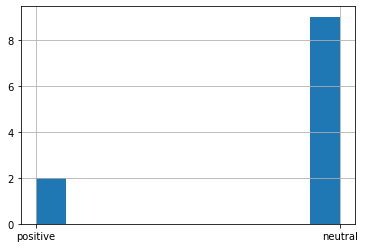

In [30]:
# documents from 1st Oct 2019 tagged with the environment topic
query = {
    'where': {
        # search over a 1 year period
        "published-at": {"gte": "2019-10-01", "lt": "2020-10-01"},
        'topics': {
            'id': {
                'eq': '7a162a73-0062-4772-9dc0-252dd862dad0'
            },
        },
        # both BP and Greta Thunberg
        'entities': {
            'id': {
                'all': [
                    '52e28982-5bd9-40d4-ab8f-7cba471f598c',
                    '2bf240bf-bbc2-4416-910a-608a3fdd967d'
                ]
            }
        }
    },
    'size': 500
}
documents = search_documents(query)
print(f'{len(documents)} documents found')

entities_df = pd.DataFrame.from_records([e for d in documents for e in d.get('entities', [])]).set_index('id')
entities_df[
    # Filter for salient mentions
    (entities_df['salience-rank'] <= 2)
].loc['52e28982-5bd9-40d4-ab8f-7cba471f598c'].sentiment.hist()

## ## Example 4: Sentiment about BP when Mexico is mentioned

100%|██████████| 1/1 [00:00<00:00,  9.47it/s]

208 documents found


<AxesSubplot:>

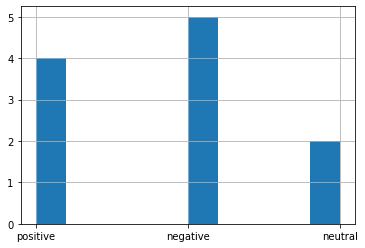

In [23]:
search_entities(name='Mexico', typ='location')[:3]

query = {
    'where': {
        # search over a 1 year period
        "published-at": {"gte": "2019-10-01", "lt": "2020-10-01"},
        'topics': {
            'id': {
                'eq': '7a162a73-0062-4772-9dc0-252dd862dad0'
            },
        },
        # both BP and Mexico
        'entities': {
            'id': {
                # to look for either entity use the key 'or'
                'all': [
                    '52e28982-5bd9-40d4-ab8f-7cba471f598c',
                    '995444c6-eae3-400c-9457-0393b51efe0e'
                ]
            }
        }
    },
    'size': 500
}
documents = search_documents(query)
print(f'{len(documents)} documents found')

entities_df = pd.DataFrame.from_records([e for d in documents for e in d.get('entities', [])
]).set_index('id')
entities_df = pd.DataFrame.from_records([e for d in documents for e in d.get('entities', [])]).set_index('id')
entities_df[
    # Filter for salient mentions
    (entities_df['salience-rank'] <= 2)
].loc['52e28982-5bd9-40d4-ab8f-7cba471f598c'].sentiment.hist()

# Example 5: People and Organisations mentioned alongside Greta Thunberg 

In [31]:
query = {
    'where': {
        "published-at": {"gte": "2019-10-01", "lt": "2020-10-01"},
        'topics': {
            'id': {
                'eq': '7a162a73-0062-4772-9dc0-252dd862dad0'
            },
        },
        'entities': {
            'id': {
                'eq': '2bf240bf-bbc2-4416-910a-608a3fdd967d'
            }
        }
    },
    'size': 500
}
documents = search_documents(query)
print(f'{len(documents)} documents found')
entities_df = pd.DataFrame.from_records([e for d in documents for e in d.get('entities', [])])
entities_df.head()

100%|██████████| 32/32 [02:52<00:00,  5.38s/it]


15832 documents found


,id,type,name,sentiment,salient,salience-rank,mentions
0,2bf240bf-bbc2-4416-910a-608a3fdd967d,person,Greta Thunberg,neutral,False,1,"[{'position': 'content', 'sentiment': 'neutral..."
1,d80ac708-9000-4207-8754-aed7e9b84f60,location,California,neutral,False,2,"[{'position': 'content', 'sentiment': 'neutral..."
2,9576c54e-0d25-4cc2-9a82-bd41eb718528,location,United States,neutral,False,3,"[{'position': 'content', 'sentiment': 'neutral'}]"
3,867d9d32-826a-34c2-9449-d53750a4370a,location,United Nations,neutral,False,4,"[{'position': 'content', 'sentiment': 'neutral'}]"
4,f39a1f83-5357-4914-a966-790bdf49f4e2,location,Saudi Arabia,neutral,False,5,"[{'position': 'content', 'sentiment': 'neutral'}]"


In [32]:
entities_df[entities_df['type'] == 'person']['name'].value_counts().head(20)

Greta Thunberg                  15832
Donald Trump                     6006
George W. Bush                    937
Barack Obama                      693
Ursula von der Leyen              671
Al Gore                           644
Pope Francis                      514
Jair Bolsonaro                    505
Presidency of George W. Bush      492
Boris Johnson                     466
Scott Morrison (politician)       430
Angela Merkel                     416
Xi Jinping                        375
Michael Bloomberg                 346
Presidency of Barack Obama        300
Joe Biden                         280
Claire Perry                      273
Emmanuel Macron                   249
Klaus Schwab                      242
Nancy Pelosi                      217
Name: name, dtype: int64

In [33]:
entities_df[entities_df['type'] == 'organisation']['name'].value_counts().head(20)

World Economic Forum                         4700
European Union                               3764
Intergovernmental Panel on Climate Change    1755
Twitter                                      1484
International Energy Agency                  1044
Thomson Reuters                               997
European Commission                           968
Greenpeace                                    878
Agence France-Presse                          844
Democratic Party (United States)              744
Republican Party (United States)              711
Future Movement                               688
World Resources Institute                     663
International Monetary Fund                   656
BlackRock                                     611
Bloomberg L.P.                                589
World Meteorological Organization             580
European Parliament                           570
PricewaterhouseCoopers                        533
United States Congress                        528
